## Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic).
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import MNIST_Loader
import seaborn as sb
import theano, random, sys, time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [13]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plotting chars

### Small

In [3]:
mpl.rcParams['figure.figsize'] = 3.75,3
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

### Large

In [4]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

## Load the data and separate set1

In [4]:
train_data, validation_data, test_data = MNIST_Loader.load_data_wrapper()
#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = np.concatenate([train_data[0], validation_data[0]], axis=0)
train_labels = train_data[1] + validation_data[1]
train_labels = np.array(train_labels)
test_images = test_data[0]
test_labels = np.array(test_data[1])
num_classes=10

In [5]:
type(train_data[1])

list

In [6]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

## Start a session

In [7]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup the network graph

In [8]:
n_input = 784
n_middle = 1024
n_out = 10
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [10], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='w2_grad_accum')
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    #@a_2 = sigma(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    #@z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    #@a_3  = sigma(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
                        name = 'delta2')
    #@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), sigmaprime(z_2),
    #@                    name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2'),
            
            tf.assign(w3_grad_accum,
                      tf.add(w3_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_w_3))),
                     name='update_omeg_w3'),
            tf.assign(b3_grad_accum, 
                      tf.add(b3_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_3))),
                     name='update_omeg_b3')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]

with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

#valid_writer = tf.summary.FileWriter(path + '/valid')
init_op = tf.global_variables_initializer()


## Start a writer

In [22]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/3lyrs_working_he2', sess.graph)

## Parametrization 1

In [23]:
#INITIALIZE THE NETWORK
sess.run(init_op,options=run_options, run_metadata=run_metadata)
zeta = 1e-3
new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
new_big_omeg_w3 = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
new_big_omeg_b3 = np.zeros(shape=[1,n_out], dtype=np.float32)

reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)
reset_w3_grad_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
reset_b3_grad_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    
start_w2 = None
start_b2 = None
start_w3 = None
start_b3 = None

end_w2 = None
end_b2 = None
end_w3 = None
end_b3 = None

old_test_data = []
historical_cross_test_acc = {}
historical_train_accuracies = {}
historical_train_costs = {}
historical_val_accuracies = {}
historical_val_costs = {}
sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
#sets = [(0,4),(5,9)]
test_labels_set = []
logging_count = 0
n_test_samples = []
for a_set in range(len(sets)):
    current_set = sets[a_set]
    current_set_name = 'set'+str(a_set)
    mask_val = [0]*num_classes
    for i in range(current_set[0], current_set[1]+1):
        mask_val[i]=1
    set_mask_val = np.array(mask_val, dtype=np.float32)
    train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                  stop=current_set[1])
    train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
    valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
    test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
    n_test_samples.append(len(test_labels_set))
    train_total = len(train_images_set)
    n_batches = len(train_images_set)/BATCH_SIZE
    print('Number of batches:{}'.format(n_batches))


    set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2), 
                  tf.assign(big_omeg_w3, new_big_omeg_w3), tf.assign(big_omeg_b3, new_big_omeg_b3)]
    sess.run(set_omegas)
    
    reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
                         tf.assign(b2_grad_accum, reset_b2_grad_accum),
                         tf.assign(w3_grad_accum, reset_w3_grad_accum),
                         tf.assign(b3_grad_accum, reset_b3_grad_accum)]
    sess.run(reset_grad_accums)
                                                                                  
    epochs = 30
    repeats = 1
    
    for repeat in range(repeats):
        tf.set_random_seed(repeat)
        print('Repeat:{}'.format(repeat))
        train_accuracies = []
        train_costs = []
        val_accuracies = []
        val_costs = []
        best_val = 0
        first_params_set = None
        last_params_set = None
        T1 = time.time()
        for i in range(epochs):
            if(i==0):
                start_w2, start_b2, start_w3, start_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: len(train_images_set)})
            print('Epoch:{}'.format((i)))
            t1 = time.time()

            ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
            train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                 set1_mask:set_mask_val})
            train_costs.append(train_cost)
            train_accuracies.append(train_accuracy)
            #train_writer.add_summary(summary,logging_count)

            print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

            ### CALCULATE VALID COSTS AND VALID ACCURACIES
            sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                  batch_size: len(valid_images_set)})
            _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                  feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
            val_costs.append(val_cost)
            val_accuracies.append(val_acc)

            if(val_acc>best_val):
                best_val = val_acc
                best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
            print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
            
            for d in range(len(old_test_data)):
                previous_set_name = 'set'+str(d)           
                prev_set = sets[d]
                prev_mask_val = [0]*num_classes
                for clas in range(prev_set[0], prev_set[1]+1):
                    prev_mask_val[clas]=1
                prev_set_mask_val = np.array(prev_mask_val, dtype=np.float32)
                sess.run(iter.initializer, feed_dict={a_1: old_test_data[d][0], y: old_test_data[d][1],
                                                  batch_size: len(old_test_data[d][0])})
                _, _, hist_test_acc, _, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:prev_set_mask_val})
                
                print('Testing accuracy on :{} while training :{} is :{}'.format(previous_set_name,
                                                                          current_set_name,
                                                                          hist_test_acc))
                if(current_set_name+'-'+previous_set_name in historical_cross_test_acc.keys()):
                    historical_cross_test_acc[current_set_name+'-'+previous_set_name].append(hist_test_acc)
                else:
                    historical_cross_test_acc[current_set_name+'-'+previous_set_name] = [hist_test_acc]
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                              batch_size: BATCH_SIZE})
            print('Training on :{}'.format(current_set))
            for j in range(n_batches):
                
                if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                    #if(a_set==1):
                    #    print(j, w_2.eval().sum(), w_3.eval().sum())
                    if(((j)% 1000 ==0)):
                        logging_count+=1
                        summary,_,_ = sess.run([merged,step, omega_step], 
                                             feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE, tau:0.5,
                                                          set1_mask:set_mask_val, eta:0.001,
                                                          lmbda:1.0e4,n_tot:train_total})
                        #train_writer.add_summary(summary, (i+1)*j)
                        train_writer.add_summary(summary, logging_count)
                    else:
                        sess.run([step, omega_step], feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE, tau:0.5,
                                                                 set1_mask:set_mask_val, eta:0.001,
                                                                  lmbda:1.0e4,n_tot:train_total})
                else:
                    print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
            print('Epoch time:{}'.format(time.time()-t1))


        sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                  batch_size: len(test_images_set)})
        _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                              feed_dict = {drop_out:0.0, 
                                                                           set1_mask:set_mask_val})
        print('Final test accuracy is:{}'.format(final_test_acc))
        end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
        update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2),tf.assign(star_w3,end_w3),
                          tf.assign(star_b3,end_b3)]
        sess.run(update_star_wbs)
        #all_final_test_accs_set1.append(final_test_acc)


        best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
                     tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
        sess.run(best_step)
        sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                  batch_size: len(test_images_set)})
        _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                 feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

        print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
        print('Time taken:{}'.format(time.time()-T1))
        if(i==epochs-1):
            if(test_acc_corresp_best_val>final_test_acc):
                end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2),tf.assign(star_w3,end_w3),
                          tf.assign(star_b3,end_b3)]
                sess.run(update_star_wbs)
            
            best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                     tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
            sess.run(best_step)
            
            first_params_set = [(start_w2, start_b2), (start_w3, start_b3)]
            last_params_set = [(end_w2, end_b2), (end_w3, end_b3)]
            
            small_omegas = [(w2_grad_accum.eval(), b2_grad_accum.eval()), (w3_grad_accum.eval(),
                           b3_grad_accum.eval())]
            
            delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                       [item[0] for item in first_params_set])
            
            delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                       [item[1] for item in first_params_set])
            delta_wbs = zip(delta_ws, delta_bs)
            
            big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                       [item[0] for item in delta_wbs])
            
            big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                       [item[1] for item in delta_wbs])
            
            big_omegas = zip(big_omegas_ws, big_omegas_bs)
            if(a_set != len(sets)-1):     
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                new_big_omeg_w3 += big_omegas[1][0]
                new_big_omeg_b3 += big_omegas[1][1]
            
            for d in range(len(old_test_data)):
                previous_set_name = 'set'+str(d)
                prev_set = sets[d]
                prev_mask_val = [0]*num_classes
                for clas in range(prev_set[0], prev_set[1]+1):
                    prev_mask_val[clas]=1
                prev_set_mask_val = np.array(prev_mask_val, dtype=np.float32)
                sess.run(iter.initializer, feed_dict={a_1: old_test_data[d][0], y: old_test_data[d][1],
                                                  batch_size: len(old_test_data[d][0])})
                _, _, hist_test_acc, _, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:prev_set_mask_val})
                
                historical_cross_test_acc[current_set_name+'-'+previous_set_name].append(hist_test_acc)
                print('Testing accuracy on :{} after training :{} is :{}'.format(previous_set_name,
                                                                          current_set_name,
                                                                          hist_test_acc))
                historical_cross_test_acc[current_set_name+'-'+current_set_name]=[test_acc_corresp_best_val]
            old_test_data.append(test_data_set)
            print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                                                            new_big_omeg_w2.mean(),
                                                            new_big_omeg_w2.std()))
            print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                                                            new_big_omeg_b2.mean(),
                                                            new_big_omeg_b2.std()))
            print('omegW3-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w3.max(),
                                                            new_big_omeg_w3.mean(),
                                                            new_big_omeg_w3.std()))
            print('omegb3-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b3.max(),
                                                            new_big_omeg_b3.mean(),
                                                            new_big_omeg_b3.std()))
            #sys.exit()
    historical_train_accuracies[current_set_name]=train_accuracies
    historical_train_costs[current_set_name]=train_costs
    historical_val_accuracies[current_set_name]=val_accuracies
    historical_val_costs[current_set_name]=val_costs
            
            
train_writer.close()
#valid_writer.close()

Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Number of batches:1152
Repeat:0
Epoch:0
training cost:2.20772242546 and training accuracy:0.594308495522
validation cost:2.20485949516 and validation accuracy:0.571554005146
Training on :(0, 1)
Epoch time:4.54452800751
Epoch:1
training cost:0.0543882250786 and training accuracy:0.996095776558
validation cost:0.0496128760278 and validation accuracy:0.996488153934
Training on :(0, 1)
Epoch time:4.35335111618
Epoch:2
training cost:0.0173014551401 and training accuracy:0.996356070042
validation cost:0.0151770692319 and validation accuracy:0.997366130352
Training on :(0, 1)
Epoch time:4.23783493042
Epoch:3
training cost:0.0124439811334 and training accuracy:0.996703088284
validation cost:0.0105488812551 and validation accuracy:0.997366130352
Training on :(0, 1)
Epoch time:4.3752758503
Epoch:4
training cost:0.0107799610123 and tr

Testing accuracy on :set0 while training :set1 is :0.999527215958
Training on :(2, 3)
Epoch time:4.50461697578
Epoch:7
training cost:0.112192161381 and training accuracy:0.961458027363
validation cost:0.0985598862171 and validation accuracy:0.966911792755
Testing accuracy on :set0 while training :set1 is :0.999527215958
Training on :(2, 3)
Epoch time:4.02665519714
Epoch:8
training cost:0.11004268378 and training accuracy:0.963276088238
validation cost:0.097419038415 and validation accuracy:0.96875
Testing accuracy on :set0 while training :set1 is :0.999527215958
Training on :(2, 3)
Epoch time:4.03833389282
Epoch:9
training cost:0.108921259642 and training accuracy:0.964912295341
validation cost:0.0965344458818 and validation accuracy:0.969669103622
Testing accuracy on :set0 while training :set1 is :0.999527215958
Training on :(2, 3)
Epoch time:4.01312303543
Epoch:10
training cost:0.106779709458 and training accuracy:0.964639604092
validation cost:0.0957153439522 and validation accuracy

Training on :(4, 5)
Epoch time:3.73360705376
Epoch:5
training cost:0.0786709412932 and training accuracy:0.971317052841
validation cost:0.0686297863722 and validation accuracy:0.97828233242
Testing accuracy on :set0 while training :set2 is :0.999054372311
Testing accuracy on :set1 while training :set2 is :0.972575902939
Training on :(4, 5)
Epoch time:4.27945399284
Epoch:6
training cost:0.0702411979437 and training accuracy:0.974634170532
validation cost:0.0593448355794 and validation accuracy:0.97828233242
Testing accuracy on :set0 while training :set2 is :0.999054372311
Testing accuracy on :set1 while training :set2 is :0.9730656147
Training on :(4, 5)
Epoch time:3.73884296417
Epoch:7
training cost:0.0640175268054 and training accuracy:0.977170705795
validation cost:0.0526843182743 and validation accuracy:0.97828233242
Testing accuracy on :set0 while training :set2 is :0.999054372311
Testing accuracy on :set1 while training :set2 is :0.9730656147
Training on :(4, 5)
Epoch time:3.73680

Repeat:0
Epoch:0
training cost:49.0008888245 and training accuracy:0.444123744965
validation cost:50.2406654358 and validation accuracy:0.453467160463
Testing accuracy on :set0 while training :set3 is :0.999054372311
Testing accuracy on :set1 while training :set3 is :0.975514173508
Testing accuracy on :set2 while training :set3 is :0.989327669144
Training on :(6, 7)
Epoch time:4.08173108101
Epoch:1
training cost:0.0464920438826 and training accuracy:0.992423534393
validation cost:0.0425009094179 and validation accuracy:0.991788327694
Testing accuracy on :set0 while training :set3 is :0.99669033289
Testing accuracy on :set1 while training :set3 is :0.971596479416
Testing accuracy on :set2 while training :set3 is :0.982924222946
Training on :(6, 7)
Epoch time:4.08504486084
Epoch:2
training cost:0.0274979751557 and training accuracy:0.994588255882
validation cost:0.0252999477088 and validation accuracy:0.993613123894
Testing accuracy on :set0 while training :set3 is :0.997163116932
Testin

Testing accuracy on :set0 while training :set3 is :0.999054372311
Testing accuracy on :set1 while training :set3 is :0.976003944874
Testing accuracy on :set2 while training :set3 is :0.989327669144
Training on :(6, 7)
Epoch time:4.13152813911
Epoch:22
training cost:0.00807881262153 and training accuracy:0.997745096684
validation cost:0.00669263862073 and validation accuracy:0.997262775898
Testing accuracy on :set0 while training :set3 is :0.999054372311
Testing accuracy on :set1 while training :set3 is :0.975514173508
Testing accuracy on :set2 while training :set3 is :0.989327669144
Training on :(6, 7)
Epoch time:4.09088087082
Epoch:23
training cost:0.00818093121052 and training accuracy:0.997925519943
validation cost:0.00679019698873 and validation accuracy:0.997262775898
Testing accuracy on :set0 while training :set3 is :0.999054372311
Testing accuracy on :set1 while training :set3 is :0.975514173508
Testing accuracy on :set2 while training :set3 is :0.989327669144
Training on :(6, 7

Epoch time:3.98341703415
Epoch:9
training cost:0.0929265171289 and training accuracy:0.968243598938
validation cost:0.067307010293 and validation accuracy:0.974576294422
Testing accuracy on :set0 while training :set4 is :0.999054372311
Testing accuracy on :set1 while training :set4 is :0.970127344131
Testing accuracy on :set2 while training :set4 is :0.990928471088
Testing accuracy on :set3 while training :set4 is :0.992950677872
Training on :(8, 9)
Epoch time:3.99142193794
Epoch:10
training cost:0.0911535844207 and training accuracy:0.968802392483
validation cost:0.0650940388441 and validation accuracy:0.975517868996
Testing accuracy on :set0 while training :set4 is :0.999527215958
Testing accuracy on :set1 while training :set4 is :0.970127344131
Testing accuracy on :set2 while training :set4 is :0.990928471088
Testing accuracy on :set3 while training :set4 is :0.992950677872
Training on :(8, 9)
Epoch time:4.0674829483
Epoch:11
training cost:0.089786529541 and training accuracy:0.9697

Epoch time:4.28892302513
Epoch:27
training cost:0.078252337873 and training accuracy:0.974483132362
validation cost:0.0474344417453 and validation accuracy:0.980225980282
Testing accuracy on :set0 while training :set4 is :0.998581588268
Testing accuracy on :set1 while training :set4 is :0.971596479416
Testing accuracy on :set2 while training :set4 is :0.991995751858
Testing accuracy on :set3 while training :set4 is :0.992950677872
Training on :(8, 9)
Epoch time:3.99735498428
Epoch:28
training cost:0.0780679285526 and training accuracy:0.974762499332
validation cost:0.0471792221069 and validation accuracy:0.982109248638
Testing accuracy on :set0 while training :set4 is :0.998581588268
Testing accuracy on :set1 while training :set4 is :0.971596479416
Testing accuracy on :set2 while training :set4 is :0.991462111473
Testing accuracy on :set3 while training :set4 is :0.992950677872
Training on :(8, 9)
Epoch time:3.97563409805
Epoch:29
training cost:0.0762803703547 and training accuracy:0.9

### Examining Final accuracy 

In [11]:
set_accs = []
for i in range(0,num_classes/2):
    set_acc =  historical_cross_test_acc['set4-set'+str(i)][-1]*100
    print('Accuracy on set {}:{} after training set {}:{} is:{}'.format(i, sets[i],\
                                    4, sets[2], set_acc))
    set_accs.append(set_acc)
n_test_samples = np.array(n_test_samples)
final_acc = (n_test_samples*set_accs).sum()/n_test_samples.sum()
print('Final accuracy on all sets:{}'.format(final_acc))

Accuracy on set 0:(0, 1) after training set 4:(4, 5) is:99.9527215958
Accuracy on set 1:(2, 3) after training set 4:(4, 5) is:97.3555326462
Accuracy on set 2:(4, 5) after training set 4:(4, 5) is:99.2529332638
Accuracy on set 3:(6, 7) after training set 4:(4, 5) is:99.2950677872
Accuracy on set 4:(8, 9) after training set 4:(4, 5) is:97.0751404762
Final accuracy on all sets:98.5900008965


### Some histograms

#### W_2

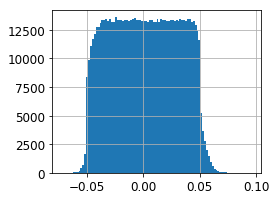

In [12]:
plt.hist(w_2.eval().flatten(), 100)
plt.grid()
plt.show()

#### Omega_W_2

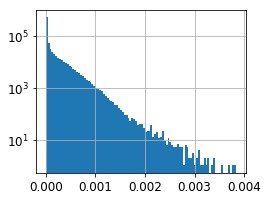

In [13]:
plt.hist(new_big_omeg_w2.flatten(),bins=100,log=True)
#plt.yscale('log')
plt.grid()
plt.show()

#### b_2

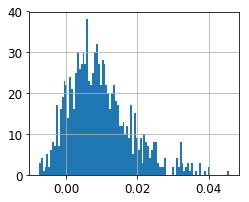

In [14]:
plt.hist(b_2.eval().flatten(), 100)
plt.grid()
plt.show()

#### Omega_b_2

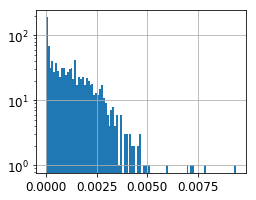

In [15]:
plt.hist(new_big_omeg_b2.flatten(),100,log=True)
plt.grid()
plt.show()

#### W_3

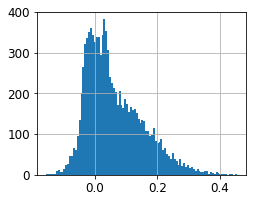

In [16]:
plt.hist(w_3.eval().flatten(), 100)
plt.grid()
plt.show()

#### Omega_W_3

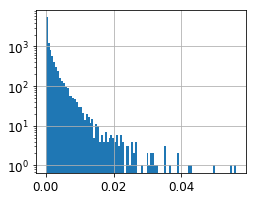

In [17]:
plt.hist(new_big_omeg_w3.flatten(),100,log=True)
plt.grid()
plt.show()

#### b_3

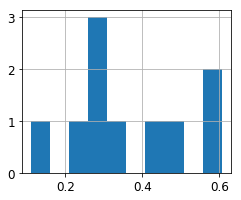

In [18]:
plt.hist(b_3.eval().flatten(), 10)
plt.grid()
plt.show()

#### Omega_b_3

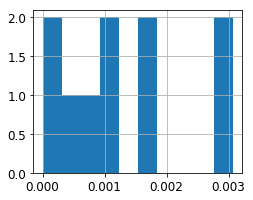

In [19]:
plt.hist(new_big_omeg_b3.flatten(),10)
plt.grid()
plt.show()

## Parametrization 2

#INITIALIZE THE NETWORK
sess.run(init_op,options=run_options, run_metadata=run_metadata)
zeta = 1e-3
omega_scale = 1.5e-1
max_clip = 1.0
new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
new_big_omeg_w3 = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
new_big_omeg_b3 = np.zeros(shape=[1,n_out], dtype=np.float32)

reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)
reset_w3_grad_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
reset_b3_grad_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    
start_w2 = None
start_b2 = None
start_w3 = None
start_b3 = None

end_w2 = None
end_b2 = None
end_w3 = None
end_b3 = None

old_test_data = []
historical_cross_test_acc = {}
historical_train_accuracies = {}
historical_train_costs = {}
historical_val_accuracies = {}
historical_val_costs = {}
sets = np.array_split(range(num_classes), int(num_classes/2))
sets = [tuple(item.tolist()) for item in sets]
n_test_samples = []
evolving_omegas = []
for a_set in range(len(sets)):
    current_set = sets[a_set]
    current_set_name = 'set'+str(a_set)
    mask_val = [0]*num_classes
    for i in range(current_set[0], current_set[1]+1):
        mask_val[i]=1
    set_mask_val = np.array(mask_val, dtype=np.float32)
    train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                  stop=current_set[1])
    train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
    valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
    test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
    n_test_samples.append(len(test_labels_set))
    train_total = len(train_images_set)
    n_batches = len(train_images_set)/BATCH_SIZE
    print('Number of batches:{}'.format(n_batches))


    set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2), 
                  tf.assign(big_omeg_w3, new_big_omeg_w3), tf.assign(big_omeg_b3, new_big_omeg_b3)]
    sess.run(set_omegas)
    
    reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
                         tf.assign(b2_grad_accum, reset_b2_grad_accum),
                         tf.assign(w3_grad_accum, reset_w3_grad_accum),
                         tf.assign(b3_grad_accum, reset_b3_grad_accum)]
    sess.run(reset_grad_accums)
                                                                                        
    epochs = 10
    repeats = 1
    
    for repeat in range(repeats):
        tf.set_random_seed(repeat)
        print('Repeat:{}'.format(repeat))
        train_accuracies = []
        train_costs = []
        val_accuracies = []
        val_costs = []
        best_val = 0
        first_params_set = None
        last_params_set = None
        logging_count = 0
        T1 = time.time()
        for i in range(epochs):
            if(i==0):
                start_w2, start_b2, start_w3, start_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: len(train_images_set)})
            print('Epoch:{}'.format((i)))
            t1 = time.time()

            ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
            train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                 set1_mask:set_mask_val})
            train_costs.append(train_cost)
            train_accuracies.append(train_accuracy)
            #train_writer.add_summary(summary,logging_count)

            print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

            ### CALCULATE VALID COSTS AND VALID ACCURACIES
            sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                  batch_size: len(valid_images_set)})
            _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                  feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
            val_costs.append(val_cost)
            val_accuracies.append(val_acc)

            if(val_acc>best_val):
                best_val = val_acc
                best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
            print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
            
            
            for d in range(len(old_test_data)):
                previous_set_name = 'set'+str(d)           
                prev_set = sets[d]
                prev_mask_val = [0]*num_classes
                for clas in range(prev_set[0], prev_set[1]+1):
                    prev_mask_val[clas]=1
                prev_set_mask_val = np.array(prev_mask_val, dtype=np.float32)
                
                sess.run(iter.initializer, feed_dict={a_1: old_test_data[d][0], y: old_test_data[d][1],
                                                  batch_size: len(old_test_data[d][0])})
                _, _, hist_test_acc, _, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:prev_set_mask_val})
                
                print('Testing accuracy on :{} while training :{} is :{}'.format(previous_set_name,
                                                                          current_set_name,
                                                                          hist_test_acc))
                if(current_set_name+'-'+previous_set_name in historical_cross_test_acc.keys()):
                    historical_cross_test_acc[current_set_name+'-'+previous_set_name].append(hist_test_acc)
                else:
                    historical_cross_test_acc[current_set_name+'-'+previous_set_name] = [hist_test_acc]
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                              batch_size: BATCH_SIZE})
            print('Training on :{}'.format(current_set))
            for j in range(n_batches):
                
                if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                    #if(a_set==1):
                    #    print(j, w_2.eval().sum(), w_3.eval().sum())
                    if(((j)% 1000 ==0)):
                        logging_count+=1
                        summary,_,_ = sess.run([merged,step, omega_step], 
                                             feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE, tau:0.5,
                                                          set1_mask:set_mask_val, eta:1.0e-3, lmbda:5.0e7,
                                                         n_tot:train_total})
                        #train_writer.add_summary(summary, (i+1)*j)
                        train_writer.add_summary(summary, logging_count)
                    else:
                        sess.run([step, omega_step], feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE, tau:0.5,
                                                                 set1_mask:set_mask_val,eta:1.0e-3,
                                                                  lmbda:5.0e7,n_tot:train_total})
                else:
                    print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
            print('Epoch time:{}'.format(time.time()-t1))


        sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                  batch_size: len(test_images_set)})
        _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                              feed_dict = {drop_out:0.0, 
                                                                           set1_mask:set_mask_val})
        print('Final test accuracy is:{}'.format(final_test_acc))
        end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
        update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2),tf.assign(star_w3,end_w3),
                          tf.assign(star_b3,end_b3)]
        sess.run(update_star_wbs)
        #all_final_test_accs_set1.append(final_test_acc)


        best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
                     tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
        sess.run(best_step)
        sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                  batch_size: len(test_images_set)})
        _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                 feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

        print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
        print('Time taken:{}'.format(time.time()-T1))
        if(i==epochs-1):
            if(test_acc_corresp_best_val>final_test_acc):
                end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2),tf.assign(star_w3,end_w3),
                          tf.assign(star_b3,end_b3)]
                sess.run(update_star_wbs)
            
            best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                     tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
            sess.run(best_step)
            
            first_params_set = [(start_w2, start_b2), (start_w3, start_b3)]
            last_params_set = [(end_w2, end_b2), (end_w3, end_b3)]
            
            small_omegas = [(w2_grad_accum.eval(), b2_grad_accum.eval()), (w3_grad_accum.eval(),
                           b3_grad_accum.eval())]
            
            delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                       [item[0] for item in first_params_set])
            
            delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                       [item[1] for item in first_params_set])
            delta_wbs = zip(delta_ws, delta_bs)
            
            big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                       [item[0] for item in delta_wbs])
            
            big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                       [item[1] for item in delta_wbs])
            
            big_omegas = zip(big_omegas_ws, big_omegas_bs)
            evolving_omegas.append(big_omegas)
            new_big_omeg_w2 += omega_scale*np.clip(big_omegas[0][0], 0, max_clip)
            new_big_omeg_b2 += omega_scale*np.clip(big_omegas[0][1],  0, max_clip)
            new_big_omeg_w3 += omega_scale*np.clip(big_omegas[1][0],  0, max_clip)
            new_big_omeg_b3 += omega_scale*np.clip(big_omegas[1][1],  0, max_clip)
            
            for d in range(len(old_test_data)):
                previous_set_name = 'set'+str(d)
                prev_set = sets[d]
                prev_mask_val = [0]*num_classes
                for clas in range(prev_set[0], prev_set[1]+1):
                    prev_mask_val[clas]=1
                prev_set_mask_val = np.array(prev_mask_val, dtype=np.float32)
                sess.run(iter.initializer, feed_dict={a_1: old_test_data[d][0], y: old_test_data[d][1],
                                                  batch_size: len(old_test_data[d][0])})
                _, _, hist_test_acc, _, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:prev_set_mask_val})
                
                historical_cross_test_acc[current_set_name+'-'+previous_set_name].append(hist_test_acc)
                print('Testing accuracy on :{} after training :{} is :{}'.format(previous_set_name,
                                                                          current_set_name,
                                                                          hist_test_acc))
                historical_cross_test_acc[current_set_name+'-'+current_set_name]=[test_acc_corresp_best_val]
                
                
            old_test_data.append(test_data_set)
            print('MAXIMUM omegW2:{}, MEAN omegW2:{}'.format(new_big_omeg_w2.max(), new_big_omeg_w2.mean()))
            print('MAXIMUM omegb2:{}, MEAN omegb2:{}'.format(new_big_omeg_b2.max(), new_big_omeg_b2.mean()))
            print('MAXIMUM omegW3:{}, MEAN omegW3:{}'.format(new_big_omeg_w3.max(), new_big_omeg_w3.mean()))
            print('MAXIMUM omegb3:{}, MEAN omegb3:{}'.format(new_big_omeg_b3.max(), new_big_omeg_b3.mean()))
            #sys.exit()
    #sys.exit()
    historical_train_accuracies[current_set_name]=train_accuracies
    historical_train_costs[current_set_name]=train_costs
    historical_val_accuracies[current_set_name]=val_accuracies
    historical_val_costs[current_set_name]=val_costs
            
            
train_writer.close()
valid_writer.close()

### Some histograms

plt.hist(w_2.eval().flatten(), 100)
plt.show()

plt.hist(new_big_omeg_w2.flatten(),100)
plt.show()

plt.hist(b_2.eval().flatten(), 100)
plt.show()

plt.hist(new_big_omeg_b2.flatten(),100)
plt.show()

plt.hist(w_3.eval().flatten(), 100)
plt.show()

plt.hist(new_big_omeg_w3.flatten(),100)
plt.show()

plt.hist(b_3.eval().flatten(), 100)
plt.show()

plt.hist(new_big_omeg_b3.flatten(),100)
plt.show()

In [20]:
### Examining final accuracy

In [21]:
set_accs = []
for i in range(0,num_classes/2):
    set_acc =  historical_cross_test_acc['set4-set'+str(i)][-1]*100
    print('Accuracy on set {}:{} after training set {}:{} is:{}'.format(i, sets[i],\
                                    4, sets[2], set_acc))
    set_accs.append(set_acc)
n_test_samples = np.array(n_test_samples)
final_acc = (n_test_samples*set_accs).sum()/n_test_samples.sum()
print('Final accuracy on all sets:{}'.format(final_acc))

Accuracy on set 0:(0, 1) after training set 4:(4, 5) is:99.9527215958
Accuracy on set 1:(2, 3) after training set 4:(4, 5) is:97.4045038223
Accuracy on set 2:(4, 5) after training set 4:(4, 5) is:98.8794028759
Accuracy on set 3:(6, 7) after training set 4:(4, 5) is:98.8922476768
Accuracy on set 4:(8, 9) after training set 4:(4, 5) is:95.7639932632
Final accuracy on all sets:98.1900006497


## Start a writer 

In [31]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/3lyrs_working_without_SI', sess.graph)

## Without SI

In [32]:
#INITIALIZE THE NETWORK
sess.run(init_op,options=run_options, run_metadata=run_metadata)
zeta = 1e-3
new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
new_big_omeg_w3 = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
new_big_omeg_b3 = np.zeros(shape=[1,n_out], dtype=np.float32)

reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)
reset_w3_grad_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
reset_b3_grad_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    
start_w2 = None
start_b2 = None
start_w3 = None
start_b3 = None

end_w2 = None
end_b2 = None
end_w3 = None
end_b3 = None

old_test_data = []
historical_cross_test_acc = {}
historical_train_accuracies = {}
historical_train_costs = {}
historical_val_accuracies = {}
historical_val_costs = {}
sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
#sets = [(0,4),(5,9)]
test_labels_set = []
logging_count = 0
n_test_samples = []
for a_set in range(len(sets)):
    current_set = sets[a_set]
    current_set_name = 'set'+str(a_set)
    mask_val = [0]*num_classes
    for i in range(current_set[0], current_set[1]+1):
        mask_val[i]=1
    set_mask_val = np.array(mask_val, dtype=np.float32)
    train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                  stop=current_set[1])
    train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
    valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
    test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
    n_test_samples.append(len(test_labels_set))
    train_total = len(train_images_set)
    n_batches = len(train_images_set)/BATCH_SIZE
    print('Number of batches:{}'.format(n_batches))


    set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2), 
                  tf.assign(big_omeg_w3, new_big_omeg_w3), tf.assign(big_omeg_b3, new_big_omeg_b3)]
    sess.run(set_omegas)
    
    reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
                         tf.assign(b2_grad_accum, reset_b2_grad_accum),
                         tf.assign(w3_grad_accum, reset_w3_grad_accum),
                         tf.assign(b3_grad_accum, reset_b3_grad_accum)]
    sess.run(reset_grad_accums)
                                                                                  
    epochs = 30
    repeats = 1
    
    for repeat in range(repeats):
        tf.set_random_seed(repeat)
        print('Repeat:{}'.format(repeat))
        train_accuracies = []
        train_costs = []
        val_accuracies = []
        val_costs = []
        best_val = 0
        first_params_set = None
        last_params_set = None
        T1 = time.time()
        for i in range(epochs):
            if(i==0):
                start_w2, start_b2, start_w3, start_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: len(train_images_set)})
            print('Epoch:{}'.format((i)))
            t1 = time.time()

            ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
            train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                 set1_mask:set_mask_val})
            train_costs.append(train_cost)
            train_accuracies.append(train_accuracy)
            #train_writer.add_summary(summary,logging_count)

            print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

            ### CALCULATE VALID COSTS AND VALID ACCURACIES
            sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                  batch_size: len(valid_images_set)})
            _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                  feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
            val_costs.append(val_cost)
            val_accuracies.append(val_acc)

            if(val_acc>best_val):
                best_val = val_acc
                best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
            print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
            
            for d in range(len(old_test_data)):
                previous_set_name = 'set'+str(d)           
                prev_set = sets[d]
                prev_mask_val = [0]*num_classes
                for clas in range(prev_set[0], prev_set[1]+1):
                    prev_mask_val[clas]=1
                prev_set_mask_val = np.array(prev_mask_val, dtype=np.float32)
                sess.run(iter.initializer, feed_dict={a_1: old_test_data[d][0], y: old_test_data[d][1],
                                                  batch_size: len(old_test_data[d][0])})
                _, _, hist_test_acc, _, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:prev_set_mask_val})
                
                print('Testing accuracy on :{} while training :{} is :{}'.format(previous_set_name,
                                                                          current_set_name,
                                                                          hist_test_acc))
                if(current_set_name+'-'+previous_set_name in historical_cross_test_acc.keys()):
                    historical_cross_test_acc[current_set_name+'-'+previous_set_name].append(hist_test_acc)
                else:
                    historical_cross_test_acc[current_set_name+'-'+previous_set_name] = [hist_test_acc]
            sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                              batch_size: BATCH_SIZE})
            print('Training on :{}'.format(current_set))
            for j in range(n_batches):
                
                if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                    #if(a_set==1):
                    #    print(j, w_2.eval().sum(), w_3.eval().sum())
                    if(((j)% 1000 ==0)):
                        logging_count+=1
                        summary,_,_ = sess.run([merged,step, omega_step], 
                                             feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE, tau:0.5,
                                                          set1_mask:set_mask_val, eta:0.001,
                                                          lmbda:0.0e4,n_tot:train_total})
                        #train_writer.add_summary(summary, (i+1)*j)
                        train_writer.add_summary(summary, logging_count)
                    else:
                        sess.run([step, omega_step], feed_dict = {drop_out:0.5,batch_size: BATCH_SIZE, tau:0.5,
                                                                 set1_mask:set_mask_val, eta:0.001,
                                                                  lmbda:0.0e4,n_tot:train_total})
                else:
                    print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
            print('Epoch time:{}'.format(time.time()-t1))


        sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                  batch_size: len(test_images_set)})
        _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                              feed_dict = {drop_out:0.0, 
                                                                           set1_mask:set_mask_val})
        print('Final test accuracy is:{}'.format(final_test_acc))
        end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
        update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2),tf.assign(star_w3,end_w3),
                          tf.assign(star_b3,end_b3)]
        sess.run(update_star_wbs)
        #all_final_test_accs_set1.append(final_test_acc)


        best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
                     tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
        sess.run(best_step)
        sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                  batch_size: len(test_images_set)})
        _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                 feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

        print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
        print('Time taken:{}'.format(time.time()-T1))
        if(i==epochs-1):
            if(test_acc_corresp_best_val>final_test_acc):
                end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2),tf.assign(star_w3,end_w3),
                          tf.assign(star_b3,end_b3)]
                sess.run(update_star_wbs)
            
            best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                     tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
            sess.run(best_step)
            
            first_params_set = [(start_w2, start_b2), (start_w3, start_b3)]
            last_params_set = [(end_w2, end_b2), (end_w3, end_b3)]
            
            small_omegas = [(w2_grad_accum.eval(), b2_grad_accum.eval()), (w3_grad_accum.eval(),
                           b3_grad_accum.eval())]
            
            delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                       [item[0] for item in first_params_set])
            
            delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                       [item[1] for item in first_params_set])
            delta_wbs = zip(delta_ws, delta_bs)
            
            big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                       [item[0] for item in delta_wbs])
            
            big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                       [item[1] for item in delta_wbs])
            
            big_omegas = zip(big_omegas_ws, big_omegas_bs)
            if(a_set != len(sets)-1):     
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                new_big_omeg_w3 += big_omegas[1][0]
                new_big_omeg_b3 += big_omegas[1][1]
            
            for d in range(len(old_test_data)):
                previous_set_name = 'set'+str(d)
                prev_set = sets[d]
                prev_mask_val = [0]*num_classes
                for clas in range(prev_set[0], prev_set[1]+1):
                    prev_mask_val[clas]=1
                prev_set_mask_val = np.array(prev_mask_val, dtype=np.float32)
                sess.run(iter.initializer, feed_dict={a_1: old_test_data[d][0], y: old_test_data[d][1],
                                                  batch_size: len(old_test_data[d][0])})
                _, _, hist_test_acc, _, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:prev_set_mask_val})
                
                historical_cross_test_acc[current_set_name+'-'+previous_set_name].append(hist_test_acc)
                print('Testing accuracy on :{} after training :{} is :{}'.format(previous_set_name,
                                                                          current_set_name,
                                                                          hist_test_acc))
                historical_cross_test_acc[current_set_name+'-'+current_set_name]=[test_acc_corresp_best_val]
            old_test_data.append(test_data_set)
            print('MAXIMUM omegW2:{}, MEAN omegW2:{}'.format(new_big_omeg_w2.max(), new_big_omeg_w2.mean()))
            print('MAXIMUM omegb2:{}, MEAN omegb2:{}'.format(new_big_omeg_b2.max(), new_big_omeg_b2.mean()))
            print('MAXIMUM omegW3:{}, MEAN omegW3:{}'.format(new_big_omeg_w3.max(), new_big_omeg_w3.mean()))
            print('MAXIMUM omegb3:{}, MEAN omegb3:{}'.format(new_big_omeg_b3.max(), new_big_omeg_b3.mean()))
            #sys.exit()
    historical_train_accuracies[current_set_name]=train_accuracies
    historical_train_costs[current_set_name]=train_costs
    historical_val_accuracies[current_set_name]=val_accuracies
    historical_val_costs[current_set_name]=val_costs
            
            
train_writer.close()
#valid_writer.close()

Test features:(2115, 784)
Length of test labels:2115
Train features:(11526, 784)
Length of train labels:11526
Valid features:(1139, 784)
Length of valid labels:1139
Number of batches:1152
Repeat:0
Epoch:0
training cost:2.30443906784 and training accuracy:0.670397341251
validation cost:2.30437278748 and validation accuracy:0.649692714214
Training on :(0, 1)
Epoch time:4.30352497101
Epoch:1
training cost:0.644062042236 and training accuracy:0.954711079597
validation cost:0.622508049011 and validation accuracy:0.955223858356
Training on :(0, 1)
Epoch time:4.39017295837
Epoch:2
training cost:0.0483111739159 and training accuracy:0.995922267437
validation cost:0.0437679290771 and validation accuracy:0.996488153934
Training on :(0, 1)
Epoch time:4.22384405136
Epoch:3
training cost:0.0176283046603 and training accuracy:0.996442854404
validation cost:0.0155012588948 and validation accuracy:0.998244047165
Training on :(0, 1)
Epoch time:5.26728892326
Epoch:4
training cost:0.0126531673595 and tra

Epoch time:3.98265600204
Epoch:7
training cost:0.123237885535 and training accuracy:0.955458581448
validation cost:0.104166850448 and validation accuracy:0.962316155434
Testing accuracy on :set0 while training :set1 is :0.999054372311
Training on :(2, 3)
Epoch time:3.99961209297
Epoch:8
training cost:0.12029927969 and training accuracy:0.956822097301
validation cost:0.10199008137 and validation accuracy:0.963235318661
Testing accuracy on :set0 while training :set1 is :0.999054372311
Training on :(2, 3)
Epoch time:4.18824100494
Epoch:9
training cost:0.117877289653 and training accuracy:0.958640098572
validation cost:0.100777059793 and validation accuracy:0.964154422283
Testing accuracy on :set0 while training :set1 is :0.999054372311
Training on :(2, 3)
Epoch time:4.33308196068
Epoch:10
training cost:0.116018503904 and training accuracy:0.961548924446
validation cost:0.0996416211128 and validation accuracy:0.967830896378
Testing accuracy on :set0 while training :set1 is :0.999054372311


Epoch time:3.74225497246
Epoch:6
training cost:0.125871092081 and training accuracy:0.949658513069
validation cost:0.117127843201 and validation accuracy:0.955577492714
Testing accuracy on :set0 while training :set2 is :0.997635960579
Testing accuracy on :set1 while training :set2 is :0.943682670593
Training on :(4, 5)
Epoch time:3.72079491615
Epoch:7
training cost:0.107397034764 and training accuracy:0.959317088127
validation cost:0.0960451737046 and validation accuracy:0.966436326504
Testing accuracy on :set0 while training :set2 is :0.997163116932
Testing accuracy on :set1 while training :set2 is :0.938295781612
Training on :(4, 5)
Epoch time:4.53310680389
Epoch:8
training cost:0.0934083983302 and training accuracy:0.965170741081
validation cost:0.080514088273 and validation accuracy:0.970385015011
Testing accuracy on :set0 while training :set2 is :0.997163116932
Testing accuracy on :set1 while training :set2 is :0.933888316154
Training on :(4, 5)
Epoch time:3.73484802246
Epoch:9
tr

Repeat:0
Epoch:0
training cost:80.889175415 and training accuracy:0.404888600111
validation cost:83.1206054688 and validation accuracy:0.372262775898
Testing accuracy on :set0 while training :set3 is :0.99669033289
Testing accuracy on :set1 while training :set3 is :0.903036236763
Testing accuracy on :set2 while training :set3 is :0.988794028759
Training on :(6, 7)
Epoch time:4.13732409477
Epoch:1
training cost:0.177095934749 and training accuracy:0.964282512665
validation cost:0.164534538984 and validation accuracy:0.97445255518
Testing accuracy on :set0 while training :set3 is :0.987706840038
Testing accuracy on :set1 while training :set3 is :0.920176327229
Testing accuracy on :set2 while training :set3 is :0.98505872488
Training on :(6, 7)
Epoch time:4.31781196594
Epoch:2
training cost:0.0636144280434 and training accuracy:0.986560821533
validation cost:0.0549878105521 and validation accuracy:0.989963531494
Testing accuracy on :set0 while training :set3 is :0.982978701591
Testing acc

Testing accuracy on :set0 while training :set3 is :0.970212757587
Testing accuracy on :set1 while training :set3 is :0.92899119854
Testing accuracy on :set2 while training :set3 is :0.98505872488
Training on :(6, 7)
Epoch time:4.06374311447
Epoch:22
training cost:0.00695542711765 and training accuracy:0.998015701771
validation cost:0.00562358926982 and validation accuracy:0.996350347996
Testing accuracy on :set0 while training :set3 is :0.970212757587
Testing accuracy on :set1 while training :set3 is :0.928011775017
Testing accuracy on :set2 while training :set3 is :0.98505872488
Training on :(6, 7)
Epoch time:4.19493508339
Epoch:23
training cost:0.00651582237333 and training accuracy:0.997925519943
validation cost:0.00495749665424 and validation accuracy:0.996350347996
Testing accuracy on :set0 while training :set3 is :0.970212757587
Testing accuracy on :set1 while training :set3 is :0.927522063255
Testing accuracy on :set2 while training :set3 is :0.98505872488
Training on :(6, 7)
Ep

Testing accuracy on :set0 while training :set4 is :0.757919609547
Testing accuracy on :set1 while training :set4 is :0.507345736027
Testing accuracy on :set2 while training :set4 is :0.983991444111
Testing accuracy on :set3 while training :set4 is :0.993454158306
Training on :(8, 9)
Epoch time:3.98204016685
Epoch:10
training cost:0.115256279707 and training accuracy:0.963866651058
validation cost:0.08367908746 and validation accuracy:0.971751391888
Testing accuracy on :set0 while training :set4 is :0.755555570126
Testing accuracy on :set1 while training :set4 is :0.499020576477
Testing accuracy on :set2 while training :set4 is :0.983991444111
Testing accuracy on :set3 while training :set4 is :0.992950677872
Training on :(8, 9)
Epoch time:3.97174596786
Epoch:11
training cost:0.115139551461 and training accuracy:0.964052915573
validation cost:0.0835602134466 and validation accuracy:0.968926548958
Testing accuracy on :set0 while training :set4 is :0.755555570126
Testing accuracy on :set1 

Epoch time:4.20186877251
Epoch:28
training cost:0.0869158580899 and training accuracy:0.974483132362
validation cost:0.0534896552563 and validation accuracy:0.980225980282
Testing accuracy on :set0 while training :set4 is :0.742789626122
Testing accuracy on :set1 while training :set4 is :0.466209590435
Testing accuracy on :set2 while training :set4 is :0.981857001781
Testing accuracy on :set3 while training :set4 is :0.992447137833
Training on :(8, 9)
Epoch time:4.16803598404
Epoch:29
training cost:0.0858504325151 and training accuracy:0.974576294422
validation cost:0.0526417084038 and validation accuracy:0.982109248638
Testing accuracy on :set0 while training :set4 is :0.740898370743
Testing accuracy on :set1 while training :set4 is :0.462291866541
Testing accuracy on :set2 while training :set4 is :0.981857001781
Testing accuracy on :set3 while training :set4 is :0.992447137833
Training on :(8, 9)
Epoch time:3.98538708687
Final test accuracy is:0.970247089863
Test accuracy corresp to 

### Examining Final accuracy

In [33]:
set_accs = []
for i in range(0,num_classes/2):
    set_acc =  historical_cross_test_acc['set4-set'+str(i)][-1]*100
    print('Accuracy on set {}:{} after training set {}:{} is:{}'.format(i, sets[i],\
                                    4, sets[2], set_acc))
    set_accs.append(set_acc)
n_test_samples = np.array(n_test_samples)
final_acc = (n_test_samples*set_accs).sum()/n_test_samples.sum()
print('Final accuracy on all sets:{}'.format(final_acc))

Accuracy on set 0:(0, 1) after training set 4:(4, 5) is:74.0898370743
Accuracy on set 1:(2, 3) after training set 4:(4, 5) is:46.2291866541
Accuracy on set 2:(4, 5) after training set 4:(4, 5) is:98.1857001781
Accuracy on set 3:(6, 7) after training set 4:(4, 5) is:99.2447137833
Accuracy on set 4:(8, 9) after training set 4:(4, 5) is:97.0751404762
Final accuracy on all sets:82.4700011832


### Some histograms

#### W_2

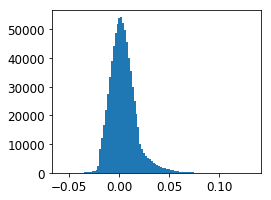

In [34]:
plt.hist(w_2.eval().flatten(), 100)
plt.show()

#### Omega_w2

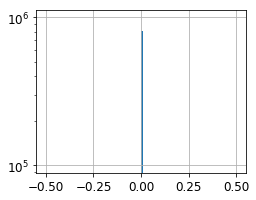

In [35]:
plt.hist(new_big_omeg_w2.flatten(),bins=100,log=True)
#plt.yscale('log')
plt.grid()
plt.show()

#### b_2

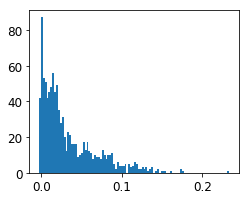

In [36]:
plt.hist(b_2.eval().flatten(), 100)
plt.show()

#### Omega_b2

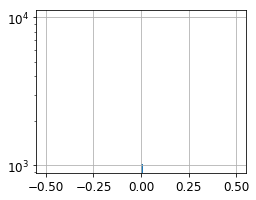

In [37]:
plt.hist(new_big_omeg_b2.flatten(),100,log=True)
plt.grid()
plt.show()

#### W_3

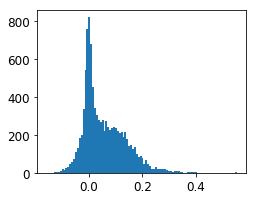

In [38]:
plt.hist(w_3.eval().flatten(), 100)
plt.show()

#### Omega_w3

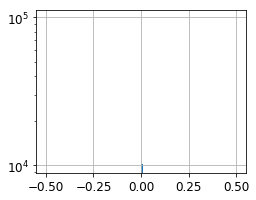

In [39]:
plt.hist(new_big_omeg_w3.flatten(),100,log=True)
plt.grid()
plt.show()

#### b_3

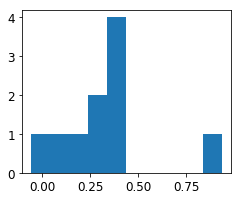

In [40]:
plt.hist(b_3.eval().flatten(), 10)
plt.show()

#### Omega_b3

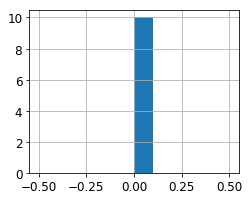

In [41]:
plt.hist(new_big_omeg_b3.flatten(),10)
plt.grid()
plt.show()